In [1]:
using Downloads
using DelimitedFiles
using Plots
using MLJ
using MLJModels
using MLJMultivariateStatsInterface
using MLJLinearModels
using MLJDecisionTreeInterface
using MLJNaiveBayesInterface
using MLJLIBSVMInterface
using Statistics
using Flux
using Flux: Losses
using Printf
using Random
using NearestNeighborModels
using CSV
using DataFrames
using DataFramesMeta
import MultivariateStats
include("unit2-multilayer-perceptron.jl")
include("unit3-overfitting.jl")
include("unit4-metrics.jl")
include("unit5-crossvalidation.jl")
include("unit6-modelcrossvalidation.jl")
include("preprocess_utils.jl")
include("ann_utils_v1.jl") 
println("Finish Imports")

Finish Imports


## Approach 1: MinMax Normalization with ANN Grid Search

In this section, we execute the full experimental pipeline for the **MinMax Normalization** approach.

**Pipeline Steps:**
1.  **Data Loading & Cleaning:** The raw dataset is loaded, and null values are handled.
2.  **Preprocessing:** Numerical features are scaled to a [0, 1] range using MinMax normalization. Categorical features are One-Hot Encoded.
3.  **Data Adaptation:** The processed data is formatted into `Float32` matrices (Samples × Features) to be compatible with the Flux.jl neural network framework.
4.  **Grid Search:** We perform an exhaustive search over:
    * **13 Network Architectures:** Varying depth (1-2 hidden layers) and width (8-64 neurons).
    * **5 Learning Rates:** Ranging from 0.05 to 0.0001 to find the optimal convergence speed.
5.  **Evaluation & Export:** The best model (selected via Validation Sensitivity) is evaluated on the Test set. Results are visualized and exported in a standardized format for the final Ensemble model.


--- STARTING APPROACH 1: MINMAX ---
>>> Loading data from: heart_disease_uci.csv
  Original Size: (920, 14)
 Categorical Null values replaced with ---> 'missingval'.
  Deleted rows in features: [:trestbps, :chol, :thalch, :oldpeak]
  Final shape: (827, 14)
------------------------

Initializing preprocessing (MinMax)...

--- init Preprocess ---
   Normalization: minmax
    Stratigfied HoldOut split: 577 train, 125 val, 125 test
    Normalizing numerical features...
    ...Normalization completed.
    Encoding categorical features (OHE)...
    ...OHE completed.
    Concatenate numerical and categorical matrices...
    Classes stored for the target: [0, 1, 2, 3, 4]
--- PREPROCESS END SUCCESFULLY ---
Data prepared successfully.
Access keys: x_train, y_train_ohe, etc.
Data adapted for ANN pipeline.
Input Dimensions (Samples x Features): (577, 31)

   Starting Grid Search (Topology + Learning Rate) for: MinMax
      [1/65] Topo: [8]        | LR: 0.050 | Val Sens: 0.5680 | Time: 19.04s
    

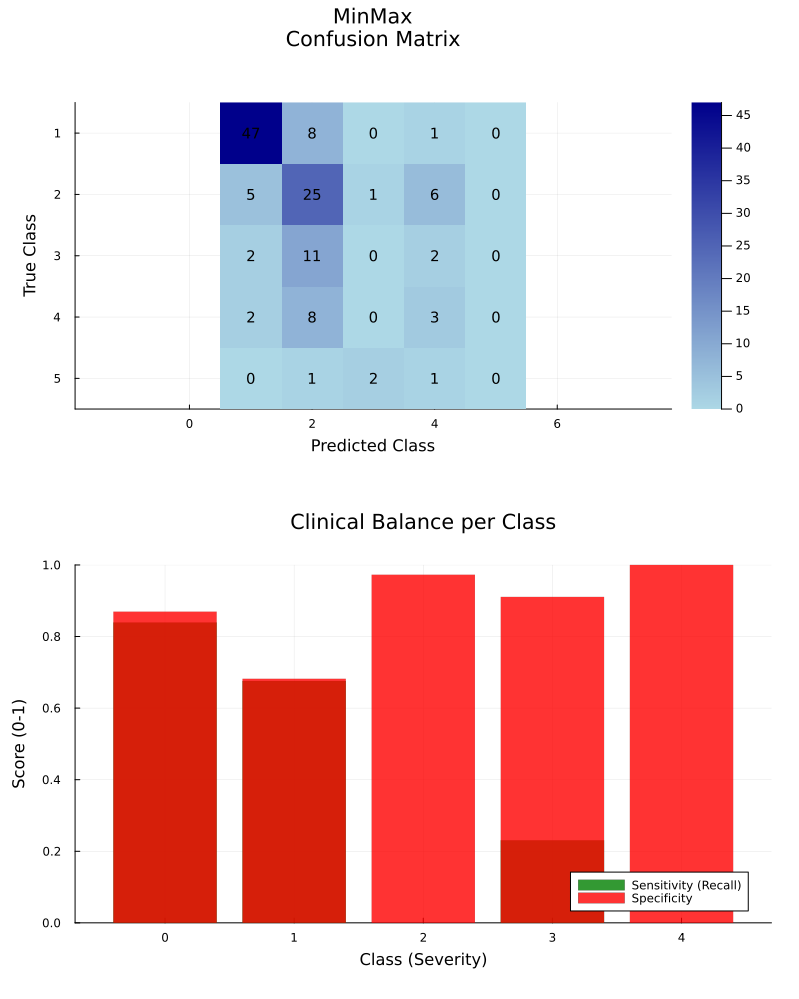

   Standardizing results for Ensemble (ANN_MinMax_Topo[64, 64])...
      EXPORT SUCCESS: Resultados_ANN_MinMax.jld2
      Binary Metrics -> Acc: 0.848 | F1: 0.867

 Saving artifacts for MinMax...
   Model Saved: Modelo_ANN_MinMax_Final.jld2
   Preds Saved: Predicciones_ANN_MinMax.jld2

Approach 1 (MinMax) completed successfully.


In [3]:
# -----------------------------------------------------------------
# APPROACH 1: MINMAX NORMALIZATION
# -----------------------------------------------------------------

println("\n--- STARTING APPROACH 1: MINMAX ---")

data_path = "heart_disease_uci.csv"

# 1. Load and Clean Data
data, num_col, cat_col, target_col = load_and_clean_data(data_path)

println("\nInitializing preprocessing (MinMax)...")

# 2. Prepare Data (Split + Normalize + Encode)
approach_1 = prepare_data(
    data,          
    num_col,       
    cat_col,       
    target_col,    
    norm_method=:minmax 
)

println("Data prepared successfully.")
println("Access keys: x_train, y_train_ohe, etc.")

# -------------------------------------------------------------------------
# 3. DATA ADAPTATION BRIDGE (SAMPLES x FEATURES)
# -------------------------------------------------------------------------
# We adapt the data structure for the ANN training function.
# NOTE: 'trainClassANN' expects input as (Samples x Features), so we do NOT transpose X here.
# We convert to Float32 for Flux efficiency and keep Y as BitMatrix for logic compatibility.

dataset_minmax = (
    # TRAINING SET
    x_train         = Float32.(approach_1.x_train),       # (Samples x Features)
    y_train_encoded = approach_1.y_train_ohe,             # (Samples x Classes)
    
    # VALIDATION SET
    x_val           = Float32.(approach_1.x_val),         
    y_val_encoded   = approach_1.y_val_ohe,
    
    # TEST SET
    x_test          = Float32.(approach_1.x_test),        
    y_test_encoded  = approach_1.y_test_ohe
)

println("Data adapted for ANN pipeline.")
println("Input Dimensions (Samples x Features): $(size(dataset_minmax.x_train))")

# -------------------------------------------------------------------------
# 4. HYPERPARAMETER GRID DEFINITION
# -------------------------------------------------------------------------
# Architectures to test (Depth and Width variations)
topologies_to_test = [
    [8], [16], [32], [64],          
    [16, 8], [32, 16], [64, 32], 
    [8, 16], [16, 32], [32, 64],
    [16, 16], [32, 32], [64, 64]      
]

# Learning Rates to test
learning_rates_to_test = [0.05, 0.01, 0.005, 0.001, 0.0001]

approach_name = "MinMax"

# -------------------------------------------------------------------------
# 5. EXECUTE GRID SEARCH
# -------------------------------------------------------------------------
# Trains all combinations, selects the winner based on Validation Sensitivity,
# and performs a final audit on the Test Set.
winner_tuple = run_grid_search_v3(
    dataset_minmax, 
    approach_name, 
    topologies_to_test, 
    learning_rates_to_test
)

# -------------------------------------------------------------------------
# 6. VISUALIZATION AND EXPORT
# -------------------------------------------------------------------------
# Extract metrics object from the winner tuple (Index 9)
metrics_object = winner_tuple[9]

println("\nGenerating Clinical Plots for $approach_name...")
generate_clinical_plots(metrics_object, approach_name)

# Export results in standardized format for Ensemble
export_standardized_results_v2(winner_tuple, dataset_minmax, approach_name)

# Save physical model and predictions
save_approach_results_v2(winner_tuple, dataset_minmax, approach_name)

println("\nApproach 1 (MinMax) completed successfully.")

## Approach 2: Principal Component Analysis (PCA)

In this section, we apply dimensionality reduction using PCA before training the Artificial Neural Network.

**Pipeline Steps:**
1.  **Data Loading & Preprocessing:** Data is loaded and normalized using **Z-Score** (critical for PCA performance).
2.  **PCA Training:**
    * The PCA model is fitted on the combined Training + Validation set to capture the maximum variance structure.
    * We retain **95% of the variance**, reducing the feature space from 31 to ~17 dimensions.
3.  **Data Transformation:** All datasets (Train, Val, Test) are projected into the reduced PCA space.
4.  **ANN Grid Search:** We run the same rigorous Grid Search (Topologies x Learning Rates) used in the MinMax approach to find the optimal configuration for this reduced dataset.
5.  **Evaluation:** Results are visualized and exported for the Ensemble.

STARTING APPROACH 2: PCA PIPELINE...
>>> Loading data from: heart_disease_uci.csv
  Original Size: (920, 14)
 Categorical Null values replaced with ---> 'missingval'.
  Deleted rows in features: [:trestbps, :chol, :thalch, :oldpeak]
  Final shape: (827, 14)
------------------------

Initializing preprocessing (Z-Score)...

--- init Preprocess ---
   Normalization: zscore
    Stratigfied HoldOut split: 577 train, 125 val, 125 test
    Normalizing numerical features...
    ...Normalization completed.
    Encoding categorical features (OHE)...
    ...OHE completed.
    Concatenate numerical and categorical matrices...
    Classes stored for the target: [0, 1, 2, 3, 4]
--- PREPROCESS END SUCCESFULLY ---

Fitting PCA Model (95% Variance)...
   PCA Transformation Complete.
   Dimensions reduced: 31 -> 17 features

Dimensions Check:
   X Train: (577, 17)
   Y Train: (577, 5)

   Starting Grid Search (Topology + Learning Rate) for: PCA
      [1/65] Topo: [8]        | LR: 0.050 | Val Sens: 0.56

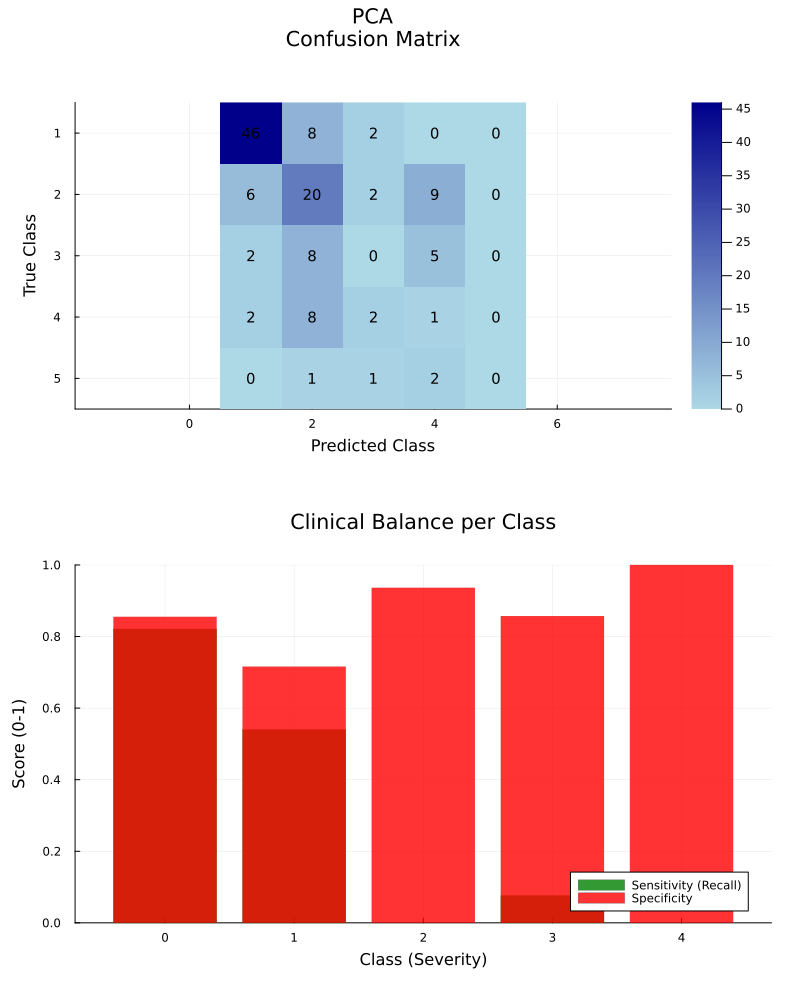

   Standardizing results for Ensemble (ANN_PCA_Topo[32, 32])...
      EXPORT SUCCESS: Resultados_ANN_PCA.jld2
      Binary Metrics -> Acc: 0.856 | F1: 0.875

 Saving artifacts for PCA...
   Model Saved: Modelo_ANN_PCA_Final.jld2
   Preds Saved: Predicciones_ANN_PCA.jld2

 Approach 2 (PCA) Completed Successfully.


In [8]:
# -------------------------------------------------------------------------
# APPROACH 2: PCA (PRINCIPAL COMPONENT ANALYSIS)
# -------------------------------------------------------------------------
println("STARTING APPROACH 2: PCA PIPELINE...")

# 1. LOAD DATA & PREPROCESS (Z-SCORE)
# -------------------------------------------------------------------------
# Load PCA Model safely
const MLJ_PCA = MLJ.@load PCA pkg=MultivariateStats verbosity=0

data_path = "heart_disease_uci.csv"
data, num_col, cat_col, target_col = load_and_clean_data(data_path)

println("\nInitializing preprocessing (Z-Score)...")
# PCA requires standardized data (mean=0, std=1)
approach_2 = prepare_data(
    data, num_col, cat_col, target_col,
    norm_method=:zscore 
)

# 2. FIT PCA & TRANSFORM
# -------------------------------------------------------------------------
println("\nFitting PCA Model (95% Variance)...")

# Combine Train + Val for better PCA fittin
x_train = approach_2.x_train
x_val   = approach_2.x_val
x_test  = approach_2.x_test

x_train_val_combined = vcat(x_train, x_val)

# Fit PCA
pca_model = MLJ_PCA(variance_ratio=0.95)
pca_machine = machine(pca_model, MLJ.table(x_train_val_combined))
MLJ.fit!(pca_machine, verbosity=0)

# Transform Data (Project to reduced space)
# We transform combined data first, then split it back to ensure consistency
x_train_val_pca_table = MLJ.transform(pca_machine, MLJ.table(x_train_val_combined))
x_test_pca_table      = MLJ.transform(pca_machine, MLJ.table(x_test))

# Convert to Matrix for Flux
mat_train_val_pca = MLJ.matrix(x_train_val_pca_table)
mat_test_pca      = MLJ.matrix(x_test_pca_table)

# Recover original split indices
n_train = size(x_train, 1)
x_train_pca_final = mat_train_val_pca[1:n_train, :]
x_val_pca_final   = mat_train_val_pca[n_train+1:end, :]

println("   PCA Transformation Complete.")
println("   Dimensions reduced: $(size(x_train, 2)) -> $(size(x_train_pca_final, 2)) features")

# -------------------------------------------------------------------------
# 3. ANN BRIDGE (ADAPT DATA TYPES & SHAPES)
# -------------------------------------------------------------------------
# Prepare the NamedTuple required by 'run_grid_search_v4'
# Note: Inputs are kept as (Samples x Features) here.

dataset_pca = (
    # TRAINING
    x_train         = Float32.(x_train_pca_final),
    y_train_encoded = approach_2.y_train_ohe,          # Original Targets
    
    # VALIDATION
    x_val           = Float32.(x_val_pca_final),
    y_val_encoded   = approach_2.y_val_ohe,
    
    # TEST
    x_test          = Float32.(mat_test_pca),
    y_test_encoded  = approach_2.y_test_ohe
)

# Safety Check: Verify Dimensions
println("\nDimensions Check:")
println("   X Train: $(size(dataset_pca.x_train))")
println("   Y Train: $(size(dataset_pca.y_train_encoded))")

# -------------------------------------------------------------------------
# 4. EXECUTE GRID SEARCH
# -------------------------------------------------------------------------
# Define Hyperparameter Grid
topologies_to_test = [
    [8], [16], [32], [64],          
    [16, 8], [32, 16], [64, 32], 
    [8, 16], [16, 32], [32, 64],
    [16, 16], [32, 32], [64, 64]      
]

# Learning Rates to test
learning_rates_to_test = [0.05, 0.01, 0.005, 0.001, 0.0001]

approach_name = "PCA"

# Run Search
winner_tuple_pca = run_grid_search_v4(
    dataset_pca, 
    approach_name, 
    topologies_to_test, 
    learning_rates_to_test
)

# -------------------------------------------------------------------------
# 5. VISUALIZATION & EXPORT
# -------------------------------------------------------------------------
# Extract metrics object
metrics_object_pca = winner_tuple_pca[9]

println("\nGenerating Clinical Plots for $approach_name...")
generate_clinical_plots(metrics_object_pca, approach_name)

# Export for Ensemble
export_standardized_results_v2(winner_tuple_pca, dataset_pca, approach_name)

# Save Physical Model
save_approach_results_v2(winner_tuple_pca, dataset_pca, approach_name)

println("\n Approach 2 (PCA) Completed Successfully.")

## Approach 3: Independent Component Analysis (ICA)

This section implements dimensionality reduction using **ICA**, a technique that seeks statistically independent components rather than just uncorrelated ones (like PCA).

**Methodology:**
1.  **Selective Transformation:** ICA is applied **only to numerical features** (5 columns). Categorical features (One-Hot Encoded) are excluded to prevent mathematical instability.
2.  **Hybrid Reconstruction:** After reducing the numerical features, they are concatenated back with the original categorical features to form the final training set.
3.  **ANN Optimization:** We execute the standard Grid Search (Topology x Learning Rate) on this new hybrid dataset.


--- STARTING APPROACH 3: ICA PIPELINE ---
>>> Loading data from: heart_disease_uci.csv
  Original Size: (920, 14)
 Categorical Null values replaced with ---> 'missingval'.
  Deleted rows in features: [:trestbps, :chol, :thalch, :oldpeak]
  Final shape: (827, 14)
------------------------
Initializing preprocessing (Z-Score)...

--- init Preprocess ---
   Normalization: zscore
    Stratigfied HoldOut split: 577 train, 125 val, 125 test
    Normalizing numerical features...
    ...Normalization completed.
    Encoding categorical features (OHE)...
    ...OHE completed.
    Concatenate numerical and categorical matrices...
    Classes stored for the target: [0, 1, 2, 3, 4]
--- PREPROCESS END SUCCESFULLY ---
Feature separation complete: 5 numerical features isolated.
Fitting ICA model (k=5)...
ICA model converged successfully.
Dataset reconstruction complete.
Final Input Shape: (577, 31)

--- RUNNING GRID SEARCH FOR ICA ---

   Starting Grid Search (Topology + Learning Rate) for: ICA
     

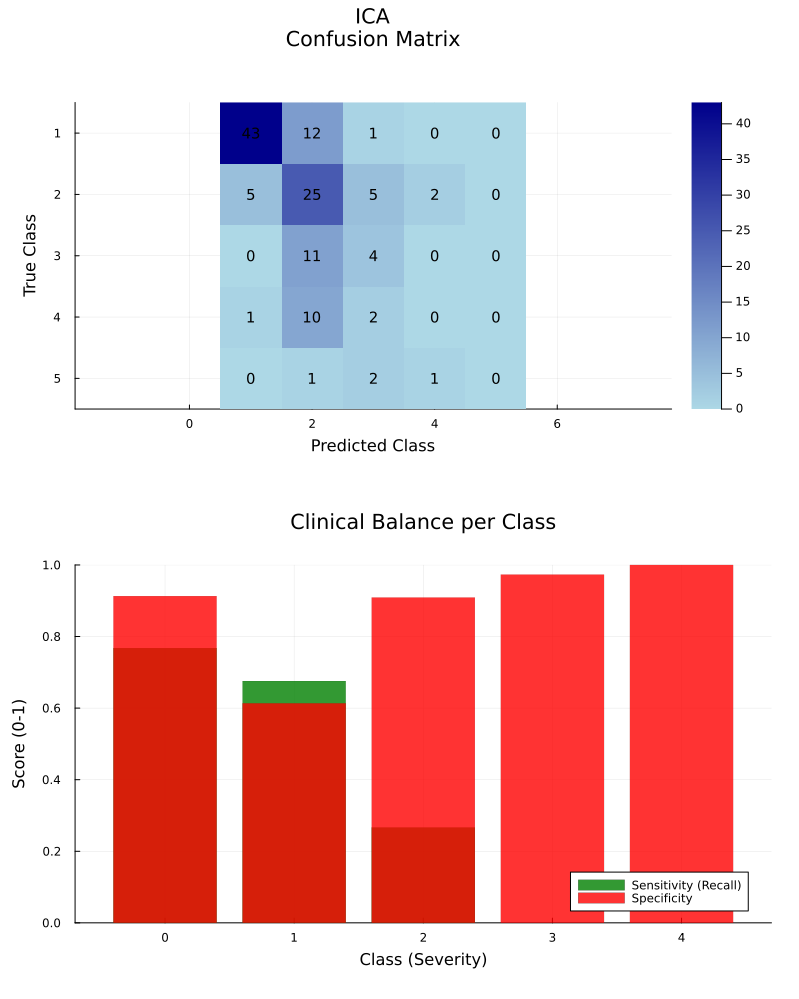

   Standardizing results for Ensemble (ANN_ICA_Topo[32, 64])...
      EXPORT SUCCESS: Resultados_ANN_ICA.jld2
      Binary Metrics -> Acc: 0.856 | F1: 0.877

 Saving artifacts for ICA...
   Model Saved: Modelo_ANN_ICA_Final.jld2
   Preds Saved: Predicciones_ANN_ICA.jld2

Approach 3 (ICA) completed successfully.


In [9]:
# -------------------------------------------------------------------------
# APPROACH 3: INDEPENDENT COMPONENT ANALYSIS (ICA)
# -------------------------------------------------------------------------
println("\n--- STARTING APPROACH 3: ICA PIPELINE ---")

# 1. LOAD DATA & PREPROCESS (Z-SCORE)
# -------------------------------------------------------------------------
# Load ICA Model safely to avoid namespace conflicts
const MLJ_ICA = MLJ.@load ICA pkg=MultivariateStats verbosity=0

data_path = "heart_disease_uci.csv"
data, num_col, cat_col, target_col = load_and_clean_data(data_path)

println("Initializing preprocessing (Z-Score)...")
# ICA requires standardized data (Z-Score) for convergence
approach_ica = prepare_data(
    data, num_col, cat_col, target_col,
    norm_method=:zscore 
)

# 2. FEATURE SEPARATION
# -------------------------------------------------------------------------
# We must apply ICA only to numerical columns. 
# 'prepare_data' returns numerical features first, followed by categorical.
n_num = length(num_col) 

# Unpack raw matrices
x_train_raw = approach_ica.x_train
x_val_raw   = approach_ica.x_val
x_test_raw  = approach_ica.x_test

# Slicing: Isolate Numerical vs Categorical parts
x_num_train = x_train_raw[:, 1:n_num]      # Numerical (Input for ICA)
x_cat_train = x_train_raw[:, n_num+1:end]  # Categorical (Keep as is)

x_num_val   = x_val_raw[:, 1:n_num]
x_cat_val   = x_val_raw[:, n_num+1:end]

x_num_test  = x_test_raw[:, 1:n_num]
x_cat_test  = x_test_raw[:, n_num+1:end]

println("Feature separation complete: $n_num numerical features isolated.")

# 3. ICA TRAINING
# -------------------------------------------------------------------------
k_components = 5 # Retain all 5 numerical components transformed
println("Fitting ICA model (k=$k_components)...")

# Configuration: Increased iterations and tolerance to ensure convergence on small datasets
ica_model = MLJ_ICA(outdim=k_components, maxiter=50000, tol=0.5)

# Fit only on Training Numerical Data
ica_machine = machine(ica_model, MLJ.table(x_num_train))

try
    MLJ.fit!(ica_machine, verbosity=0)
    println("ICA model converged successfully.")
catch e
    println("Warning: ICA convergence issue: $e")
    println("Proceeding with best-effort transformation.")
end

# 4. TRANSFORMATION & RECONSTRUCTION
# -------------------------------------------------------------------------
# A. Transform Numerical Data
x_num_train_ica = MLJ.matrix(MLJ.transform(ica_machine, MLJ.table(x_num_train)))
x_num_val_ica   = MLJ.matrix(MLJ.transform(ica_machine, MLJ.table(x_num_val)))
x_num_test_ica  = MLJ.matrix(MLJ.transform(ica_machine, MLJ.table(x_num_test)))

# B. Re-assemble Dataset (Concatenate transformed numerical + original categorical)
x_train_final_ica = hcat(x_num_train_ica, x_cat_train)
x_val_final_ica   = hcat(x_num_val_ica,   x_cat_val)
x_test_final_ica  = hcat(x_num_test_ica,  x_cat_test)

println("Dataset reconstruction complete.")
println("Final Input Shape: $(size(x_train_final_ica))")

# -------------------------------------------------------------------------
# 5. ANN DATA ADAPTATION
# -------------------------------------------------------------------------
# Pack data into NamedTuple for the experimental pipeline
dataset_ica = (
    # Training (Samples x Features)
    x_train         = Float32.(x_train_final_ica),
    y_train_encoded = approach_ica.y_train_ohe,
    
    # Validation
    x_val           = Float32.(x_val_final_ica),
    y_val_encoded   = approach_ica.y_val_ohe,
    
    # Test
    x_test          = Float32.(x_test_final_ica),
    y_test_encoded  = approach_ica.y_test_ohe
)

# -------------------------------------------------------------------------
# 6. EXECUTE GRID SEARCH
# -------------------------------------------------------------------------
topologies_to_test = [
    [8], [16], [32], [64],          
    [16, 8], [32, 16], [64, 32], 
    [8, 16], [16, 32], [32, 64],
    [16, 16], [32, 32], [64, 64]      
]

learning_rates_to_test = [0.05, 0.01, 0.005, 0.001, 0.0001]
approach_name = "ICA"

println("\n--- RUNNING GRID SEARCH FOR ICA ---")

# 1. Search for Best Model
winner_tuple_ica = run_grid_search_v4(
    dataset_ica, 
    approach_name, 
    topologies_to_test, 
    learning_rates_to_test
)

# 2. Visualization
metrics_object_ica = winner_tuple_ica[9]
println("\nGenerating Clinical Plots...")
generate_clinical_plots(metrics_object_ica, approach_name)

# 3. Export for Ensemble
export_standardized_results_v2(winner_tuple_ica, dataset_ica, approach_name)

# 4. Save Physical Model
save_approach_results_v2(winner_tuple_ica, dataset_ica, approach_name)

println("\nApproach 3 (ICA) completed successfully.")

## Approach 4: Rigorous Cross-Validation (MinMax Normalization)

In this approach, we move beyond simple train/validation splits and implement a robust **k-Fold Cross-Validation** strategy on the standard MinMax-normalized dataset.

**Objective:**
To ensure that the selected ANN architecture and hyperparameters are statistically robust and not biased by a specific random split of the data.

**Experimental Pipeline:**

1.  **Strict Hold-Out Split (85/15):**
    * **Test Set (15%):** A completely isolated subset reserved *exclusively* for the final audit. It is never seen during the grid search.
    * **Development Set (85%):** The remaining data used for training and model selection.

2.  **5-Fold Cross-Validation:**
    * The Development Set is divided into 5 stratified folds.
    * We execute a **Grid Search** over various **Topologies** (e.g., `[16]`, `[32, 16]`) and **Learning Rates**.
    * Each configuration is trained and evaluated 5 times. The performance is averaged to determine the stability of the model.

3.  **Winner Selection & Retraining:**
    * The configuration with the highest **Mean Accuracy** across the folds is selected.
    * A fresh model with these optimal parameters is **retrained on the full Development Set (85%)** to maximize the information learned.

4.  **Final Evaluation:**
    * The final retrained model is evaluated on the held-out **Test Set (15%)**.
    * Results are visualized (Confusion Matrix) and exported in the standardized format for the Ensemble model.


--- STARTING APPROACH 4: CROSS-VALIDATION PIPELINE ---
>>> Loading data from: heart_disease_uci.csv
  Original Size: (920, 14)
 Categorical Null values replaced with ---> 'missingval'.
  Deleted rows in features: [:trestbps, :chol, :thalch, :oldpeak]
  Final shape: (827, 14)
------------------------
Data Split: Dev=702 (85%), Test=125 (15%)
CV Indices Generated (5 folds).

--- STARTING GRID SEARCH (CV) ---
Topo: [8]        | LR: 0.0500 -> Mean Acc: 58.67% (+-4.02)
Topo: [8]        | LR: 0.0100 -> Mean Acc: 59.11% (+-3.25)
Topo: [8]        | LR: 0.0050 -> Mean Acc: 59.25% (+-2.36)
Topo: [8]        | LR: 0.0010 -> Mean Acc: 58.54% (+-1.55)
Topo: [8]        | LR: 0.0001 -> Mean Acc: 37.44% (+-10.05)
Topo: [16]       | LR: 0.0500 -> Mean Acc: 59.54% (+-4.45)
Topo: [16]       | LR: 0.0100 -> Mean Acc: 59.68% (+-2.84)
Topo: [16]       | LR: 0.0050 -> Mean Acc: 59.96% (+-4.04)
Topo: [16]       | LR: 0.0010 -> Mean Acc: 58.97% (+-4.61)
Topo: [16]       | LR: 0.0001 -> Mean Acc: 50.73% (+-5.03

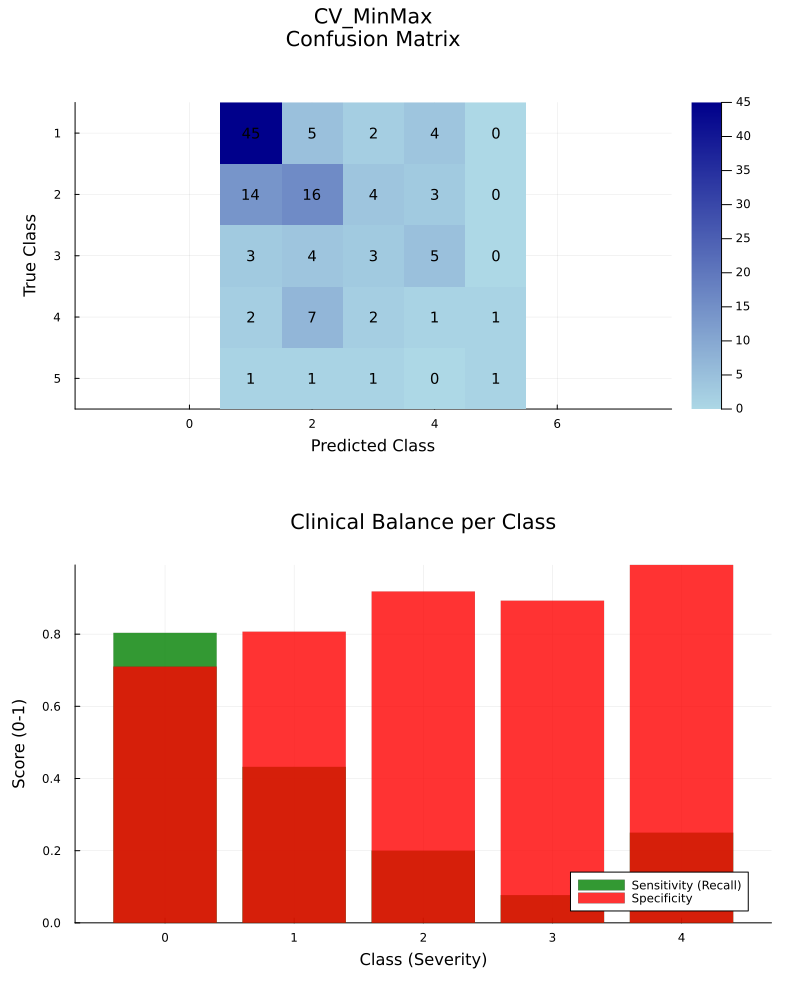

Exporting results...
   Standardizing results for Ensemble (ANN_CV_MinMax_Topo[32])...
      EXPORT SUCCESS: Resultados_ANN_CV_MinMax.jld2
      Binary Metrics -> Acc: 0.752 | F1: 0.76

 Saving artifacts for CV_MinMax...
   Model Saved: Modelo_ANN_CV_MinMax_Final.jld2
   Preds Saved: Predicciones_ANN_CV_MinMax.jld2

Approach 4 (Cross-Validation) completed successfully.


In [15]:
# -------------------------------------------------------------------------
# APPROACH 4: ANN WITH CROSS-VALIDATION (NO PCA)
# -------------------------------------------------------------------------
println("\n--- STARTING APPROACH 4: CROSS-VALIDATION PIPELINE ---")

data_path = "heart_disease_uci.csv"
data, num_col, cat_col, target_col = load_and_clean_data(data_path)

Random.seed!(1234)

# 1. INITIAL DATA SPLIT (85% DEV / 15% TEST)
(idx_dev, _, idx_test) = stratified_holdOut(data[!, target_col], 0.0, 0.15) 

dev_data  = data[idx_dev, :]
test_data = data[idx_test, :]

println("Data Split: Dev=$(nrow(dev_data)) (85%), Test=$(nrow(test_data)) (15%)")

# Prepare inputs for the Universal CV function
dev_num = select(dev_data, num_col)
dev_cat = select(dev_data, cat_col)
dev_targets = dev_data[!, target_col]

# Generate 5-Fold Stratified Indices for CV
k_folds = 5

# Define simple CV function if not available in unit5
function simple_cv_indices(targets, k)
    n = length(targets)
    folds = zeros(Int, n)
    shuffled_idx = randperm(n)
    fold_size = floor(Int, n/k)
    for i in 1:k
        start_i = (i-1)*fold_size + 1
        end_i = i == k ? n : i*fold_size
        folds[shuffled_idx[start_i:end_i]] .= i
    end
    return folds
end

cv_indices = simple_cv_indices(dev_targets, k_folds)
println("CV Indices Generated ($k_folds folds).")


# -------------------------------------------------------------------------
# 2. HYPERPARAMETER GRID SEARCH (CROSS-VALIDATION)
# -------------------------------------------------------------------------
println("\n--- STARTING GRID SEARCH (CV) ---")

topologies = [
    [8], [16], [32], [64],          
    [16, 8], [32, 16], [64, 32], 
    [8, 16], [16, 32], [32, 64],
    [16, 16], [32, 32], [64, 64]      
]

learning_rates = [0.05, 0.01, 0.005, 0.001, 0.0001]

results_cv = []

for topo in topologies
    for lr in learning_rates
        
        hyperparams = Dict(
            :topology => topo,
            :learningRate => lr,
            :maxEpochs => 1000,
            :validationRatio => 0.2
        )
        
        # Execute Cross-Validation using universal function
        mean_acc, std_acc = universalCrossValidation1(
            :ANN, 
            hyperparams, 
            dev_num, 
            dev_cat, 
            dev_targets, 
            cv_indices
        )
        
        @printf("Topo: %-10s | LR: %.4f -> Mean Acc: %.2f%% (+-%.2f)\n", 
                string(topo), lr, mean_acc*100, std_acc*100)
        
        push!(results_cv, (topo, lr, mean_acc, std_acc))
    end
end

# -------------------------------------------------------------------------
# 3. SELECT BEST MODEL AND RETRAIN
# -------------------------------------------------------------------------
# Sort by Mean Accuracy (Index 3)
sort!(results_cv, by = x -> x[3], rev = true)
winner = results_cv[1]
(best_topo, best_lr, best_acc, _) = winner

println("\nWINNER CONFIGURATION: Topo $best_topo, LR $best_lr (CV Acc: $(round(best_acc*100, digits=2))%)")
println("\n--- TRAINING FINAL MODEL ON FULL DEV SET ---")

# A. Fit Preprocessing on Full Dev Set (MinMax + OHE)
params_proc = fit_preprocess(Matrix{Float64}(dev_num), dev_cat)

# B. Apply Preprocessing to Dev and Test
X_dev_proc = Float32.(apply_preprocess(Matrix{Float64}(dev_num), dev_cat, params_proc))

test_num = select(test_data, num_col)
test_cat = select(test_data, cat_col)
X_test_proc = Float32.(apply_preprocess(Matrix{Float64}(test_num), test_cat, params_proc))

# C. Prepare Targets
classes = sort(unique(dev_targets))
y_dev_ohe  = oneHotEncoding(dev_targets, classes)
y_test_ohe = oneHotEncoding(test_data[!, target_col], classes)

# D. Train Final ANN
# We use a dummy validation set here because we want to use ALL Dev data for training.
# Early stopping will rely on training loss convergence or max epochs.
final_ann, _, _, _ = trainClassANN(
    best_topo,
    (X_dev_proc, y_dev_ohe);
    validationDataset = (Array{Float32}(undef,0,0), falses(0,0)), 
    learningRate = best_lr,
    maxEpochs = 1000,
    showText = false
)

# -------------------------------------------------------------------------
# 4. FINAL EVALUATION & EXPORT
# -------------------------------------------------------------------------
println("\n--- FINAL EVALUATION ON TEST SET ---")

# Predict
raw_preds = final_ann(X_test_proc')' # Transpose for Flux
y_pred_bool = classifyOutputs(raw_preds)

# Metrics
metrics = confusionMatrix(y_pred_bool, y_test_ohe)
println("FINAL TEST ACCURACY: $(round(metrics.accuracy * 100, digits=2))%")
println("FINAL TEST F1:       $(round(metrics.f_score, digits=3))")

# --- A. VISUALIZATION ---
approach_name = "CV_MinMax"
println("\nGenerating Clinical Plots for $approach_name...")
generate_clinical_plots(metrics, approach_name)

# --- B. EXPORT (Standardized for Ensemble) ---
# We create a dummy tuple to reuse your existing export function
# Tuple structure: (Topo, Acc, F1, Sens, Spec, Prec, Time, MODEL)
dummy_winner_tuple = (
    best_topo, 
    metrics.accuracy * 100, 
    metrics.f_score, 
    metrics.sensitivity, 
    metrics.specificity, 
    metrics.ppv, 
    0.0, # Time not tracked for final training here
    final_ann
)

# Create a temporary dataset object for the exporter function
# Note: 'X_test_proc' is (Samples x Features), exporter expects this and transposes internally.
dataset_cv_export = (
    x_test = X_test_proc,
    y_test_encoded = y_test_ohe
)

println("Exporting results...")
export_standardized_results_v2(dummy_winner_tuple, dataset_cv_export, approach_name)
save_approach_results_v2(dummy_winner_tuple, dataset_cv_export, approach_name)

println("\nApproach 4 (Cross-Validation) completed successfully.")

## Approach 5: PCA with Cross-Validation

This approach combines the dimensionality reduction benefits of **PCA** with the statistical robustness of **Cross-Validation**.

**Methodology:**
To strictly avoid Data Leakage, the PCA transformation is learned **inside each cross-validation fold**.

1.  **Data Split (85/15):**
    * **Test Set (15%):** Completely isolated for final auditing.
    * **Dev Set (85%):** Used for Cross-Validation and final training.

2.  **Rigorous Cross-Validation:**
    * In each fold of the CV, PCA parameters are learned solely from the *training* portion of that fold.
    * The validation portion is then transformed using those parameters.
    * This ensures the validation score reflects true generalization capability.

3.  **Model Selection:**
    * We perform a Grid Search over ANN Topologies and Learning Rates.
    * The configuration with the highest mean CV accuracy is selected.

4.  **Final Retraining:**
    * Once the best hyperparameters are found, we learn a global PCA transformation on the full **Dev Set**.
    * A final ANN model is trained on this PCA-transformed data.

5.  **Final Audit:**
    * The external Test Set is transformed using the global PCA and evaluated against the final model.


--- STARTING APPROACH 5: PCA + CROSS-VALIDATION PIPELINE ---
>>> Loading data from: heart_disease_uci.csv
  Original Size: (920, 14)
 Categorical Null values replaced with ---> 'missingval'.
  Deleted rows in features: [:trestbps, :chol, :thalch, :oldpeak]
  Final shape: (827, 14)
------------------------
Data Split: Dev=702 (85%), Test=125 (15%)
CV Indices Generated (5 folds).

--- STARTING GRID SEARCH (PCA-CV) ---
Topo: [8]        | LR: 0.0500 | PCA: 15 -> Acc: 57.70% (+-2.66)
Topo: [8]        | LR: 0.0100 | PCA: 15 -> Acc: 59.40% (+-3.61)
Topo: [8]        | LR: 0.0050 | PCA: 15 -> Acc: 58.26% (+-2.32)
Topo: [8]        | LR: 0.0010 | PCA: 15 -> Acc: 58.12% (+-1.27)
Topo: [8]        | LR: 0.0001 | PCA: 15 -> Acc: 33.30% (+-11.41)
Topo: [16]       | LR: 0.0500 | PCA: 15 -> Acc: 58.54% (+-2.88)
Topo: [16]       | LR: 0.0100 | PCA: 15 -> Acc: 59.54% (+-2.69)
Topo: [16]       | LR: 0.0050 | PCA: 15 -> Acc: 57.40% (+-2.59)
Topo: [16]       | LR: 0.0010 | PCA: 15 -> Acc: 57.69% (+-1.69)
To

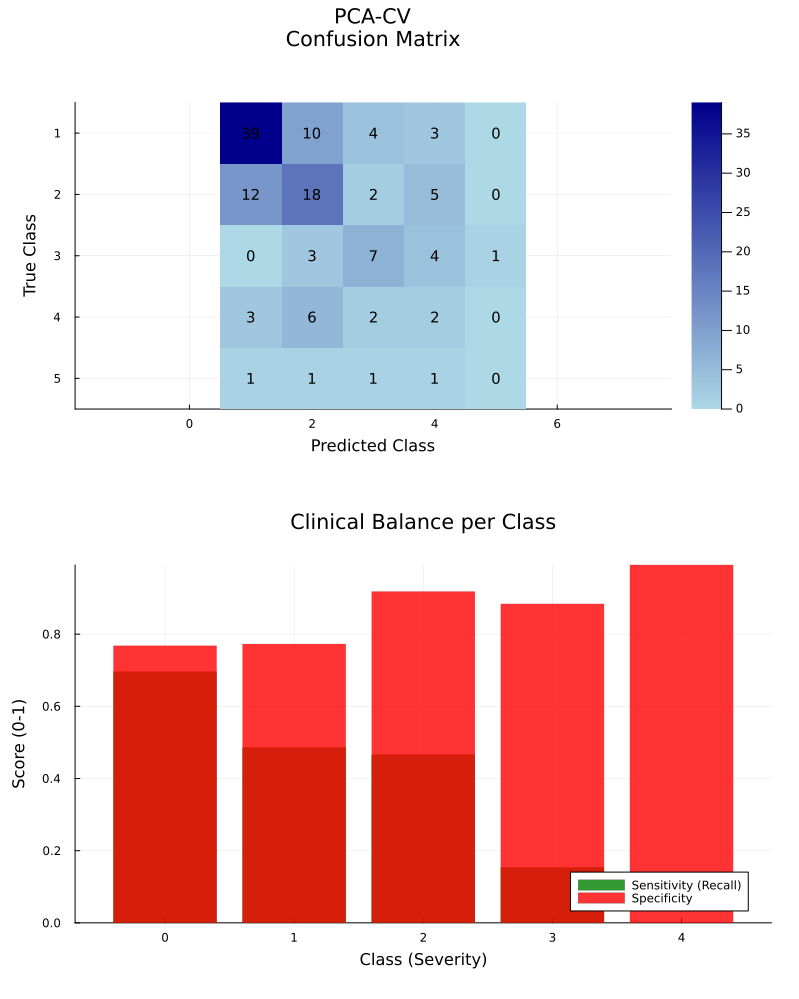

   Standardizing results for Ensemble (ANN_PCA_CV_Topo[16, 32])...
      EXPORT SUCCESS: Resultados_ANN_PCA_CV.jld2
      Binary Metrics -> Acc: 0.736 | F1: 0.763

 Saving artifacts for PCA_CV...
   Model Saved: Modelo_ANN_PCA_CV_Final.jld2
   Preds Saved: Predicciones_ANN_PCA_CV.jld2

Approach 5 (PCA+CV) Completed Successfully.


In [17]:
# -------------------------------------------------------------------------
# APPROACH 5: PCA WITH CROSS-VALIDATION
# -------------------------------------------------------------------------
println("\n--- STARTING APPROACH 5: PCA + CROSS-VALIDATION PIPELINE ---")

data_path = "heart_disease_uci.csv"
data, num_col, cat_col, target_col = load_and_clean_data(data_path)

Random.seed!(1234)

# 1. INITIAL DATA SPLIT (85% DEV / 15% TEST)
# -------------------------------------------------------------------------
# Reserve 15% for the final test. The remaining 85% is the Development set.
(idx_dev, _, idx_test) = stratified_holdOut(data[!, target_col], 0.0, 0.15) 

dev_data  = data[idx_dev, :]
test_data = data[idx_test, :]

println("Data Split: Dev=$(nrow(dev_data)) (85%), Test=$(nrow(test_data)) (15%)")

# Prepare inputs for the Universal CV function
dev_num = select(dev_data, num_col)
dev_cat = select(dev_data, cat_col)
dev_targets = dev_data[!, target_col]

# Generate 5-Fold Stratified Indices for CV
k_folds = 5
cv_indices = simple_cv_indices(dev_targets, k_folds)
println("CV Indices Generated ($k_folds folds).")


# -------------------------------------------------------------------------
# 2. GRID SEARCH WITH SECURE PCA
# -------------------------------------------------------------------------
println("\n--- STARTING GRID SEARCH (PCA-CV) ---")

topologies = [
    [8], [16], [32], [64],          
    [16, 8], [32, 16], [64, 32], 
    [8, 16], [16, 32], [32, 64],
    [16, 16], [32, 32], [64, 64]      
]

learning_rates = [0.05, 0.01, 0.005, 0.001, 0.0001]
pca_components = 15

results_cv = []

for topo in topologies
    for lr in learning_rates
        
        hyperparams = Dict(
            :topology => topo,
            :learningRate => lr,
            :maxEpochs => 1000,
            :validationRatio => 0.2, # Internal split for ANN Early Stopping
            :pca_components => pca_components # K for PCA inside each fold
        )
        
        # Execute CV using the leakage-free PCA function
        mean_acc, std_acc = universalCrossValidation_PCA(
            :ANN, 
            hyperparams, 
            dev_num, 
            dev_cat, 
            dev_targets, 
            cv_indices
        )
        
        @printf("Topo: %-10s | LR: %.4f | PCA: %d -> Acc: %.2f%% (+-%.2f)\n", 
                string(topo), lr, pca_components, mean_acc*100, std_acc*100)
        
        push!(results_cv, (topo, lr, mean_acc))
    end
end

# -------------------------------------------------------------------------
# 3. SELECT WINNER AND RETRAIN ON FULL DEV SET
# -------------------------------------------------------------------------
# Sort by Accuracy
sort!(results_cv, by = x -> x[3], rev = true)
winner = results_cv[1]
(best_topo, best_lr, best_acc) = winner

println("\nWINNER: Topo $best_topo, LR $best_lr (CV Acc: $(round(best_acc*100, digits=2))%)")
println("\n--- FINAL RETRAINING PIPELINE (Fit Preprocess -> Fit PCA -> Train ANN) ---")

# A. GLOBAL PREPROCESSING (Z-Score + OHE)
# Learn parameters on the full Dev Set (85%)
params_proc = fit_preprocess_zscore(Matrix{Float64}(dev_num), dev_cat)

# Apply to Dev and Test
X_dev_hyb  = Float32.(apply_preprocess_zscore(Matrix{Float64}(dev_num), dev_cat, params_proc))

test_num   = select(test_data, num_col)
test_cat   = select(test_data, cat_col)
X_test_hyb = Float32.(apply_preprocess_zscore(Matrix{Float64}(test_num), test_cat, params_proc))

# B. GLOBAL PCA
# Learn PCA rotation on the full preprocessed Dev Set
# Note: Transpose input for MultivariateStats (Features x Samples)
pca_m = MultivariateStats.fit(MultivariateStats.PCA, X_dev_hyb'; maxoutdim=pca_components)

# Project Dev and Test sets to the reduced space
X_dev_final  = Float32.(MultivariateStats.transform(pca_m, X_dev_hyb')') # (Samples x 15)
X_test_final = Float32.(MultivariateStats.transform(pca_m, X_test_hyb')') # (Samples x 15)

println("PCA Dimension Reduction: $(size(X_dev_hyb, 2)) -> $(size(X_dev_final, 2)) features")

# C. ANN TRAINING
classes = sort(unique(dev_targets))
y_dev_ohe = oneHotEncoding(dev_targets, classes)

# Train final ANN on reduced data
final_ann, train_h, _, _ = trainClassANN(
    best_topo,
    (X_dev_final, y_dev_ohe); 
    validationDataset = (Array{Float32}(undef,0,0), falses(0,0)), 
    learningRate = best_lr,
    maxEpochs = 1000,
    showText = false
)

# -------------------------------------------------------------------------
# 4. PACKAGING AND EXPORT
# -------------------------------------------------------------------------
println("\n--- FINAL EVALUATION & EXPORT ---")

# Prepare Test Targets
y_test_targets = test_data[!, target_col]
y_test_ohe = oneHotEncoding(y_test_targets, classes) # (Samples x Classes)

# Wrapper dataset for export functions
# Note: X_test_final is (Samples x Features)
dataset_pca_cv = (
    x_test = X_test_final,       
    y_test_encoded = y_test_ohe,
    x_train = X_dev_final,       # For reference
    y_train_encoded = y_dev_ohe
)

# Generate Predictions
# 1. Predecir con Flux (devuelve 5 x N)
raw_preds = final_ann(X_test_final') 

# 2. Transponer antes de clasificar (N x 5) para que coincida con y_test_ohe
raw_preds_T = permutedims(raw_preds)

# 3. Clasificar (ahora será N x 5)
y_pred_bool = classifyOutputs(raw_preds_T)

# 4. Métricas (Ahora sí coinciden: N x 5 vs N x 5)
m = confusionMatrix(y_pred_bool, y_test_ohe)

# Create a dummy winner tuple structure for compatibility with export functions
dummy_winner = (best_topo, m.accuracy*100, m.f_score, m.sensitivity, m.specificity, m.ppv, 0.0, final_ann)

println("FINAL TEST ACCURACY: $(round(m.accuracy * 100, digits=2))%")
println("FINAL TEST F1:       $(round(m.f_score, digits=3))")

# 1. Generate Plots
println("\nGenerating Clinical Plots...")
generate_clinical_plots(m, "PCA-CV")

# 2. Export Standardized Results
export_standardized_results_v2(dummy_winner, dataset_pca_cv, "PCA_CV")

# 3. Save Physical Model
save_approach_results_v2(dummy_winner, dataset_pca_cv, "PCA_CV")

println("\nApproach 5 (PCA+CV) Completed Successfully.")